In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import string
import seaborn as sns
import math
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import *
import sklearn.model_selection
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_extraction.text import *

import emot

[nltk_data] Downloading package wordnet to /home/victor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/victor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/victor/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Client support

# 1. Data extraction

In [2]:
filename = "../../data/extraction_twint/tweets_data/data_service_clients/with_reply_time/amazon.csv"

In [3]:
full_df = pd.read_csv(filename)
df = full_df[["tweet","reply_time"]].copy()
df= df.rename(columns={'tweet':'raw'})

In [4]:
full_df.columns

Index(['id', 'conversation_id', 'created_at', 'timezone', 'user_id',
       'username', 'name', 'place', 'tweet', 'mentions', 'urls', 'photos',
       'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'cashtags', 'link', 'retweet', 'quote_url', 'video', 'near', 'geo',
       'source', 'user_rt_id', 'user_rt', 'retweet_id', 'reply_to',
       'retweet_date', 'translate', 'trans_src', 'trans_dest', 'datetime',
       'reply_time'],
      dtype='object')

In [5]:
df.columns

Index(['raw', 'reply_time'], dtype='object')

In [6]:
df.head()

,raw,reply_time
0,Wt a disgusting amazon ! @JeffBezos @AmitAgarw...,NaN
1,"""On the way but running late"" is what I always...",0 days 00:02:42.000000000
2,7866061659 is call for refund your money this ...,NaN
3,It’s from Amazon @AmazonUK,NaN
4,Check DM. \nI have sent details.,NaN


In [7]:
df.shape

(6839, 2)

In [8]:
sum(df.reply_time.isnull())

1657

In [9]:
#reply time to timedelta
df['reply_time']=df['reply_time'].map(pd.to_timedelta)

#reply time in minutes
df['reply_time']=df['reply_time'].map(lambda x: x.days*1440 + x.seconds//60)

In [12]:
df["raw"] = df["raw"].astype(str)

In [13]:
df.dtypes

raw            object
reply_time    float64
dtype: object

# 2. Pre-processing

In [14]:
df['has_reply'] = df['reply_time'].map(lambda x : not(math.isnan(x)))

In [15]:
df['has_reply'].value_counts()

True     5182
False    1657
Name: has_reply, dtype: int64

### Change text

In [16]:
def remove_uppercase(text):
    return text.lower()
    
def remove_punctuation(text):
    """custom function to remove the punctuation"""  
    PUNCT_TO_REMOVE = string.punctuation
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def remove_stopwords(text):
    """custom function to remove the stopwords"""
    STOPWORDS = set(stopwords.words('english'))
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def remove_frequent_words(text):
    FREQWORDS = get_frequent_words(df)
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

# def remove_urls(text):
#     url_pattern = re.compile(r'https?://\S+|www\.\S+')
#     expression = re.compile(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*')
#     text =  url_pattern.sub(r'', text)
#     return expression.sub(r'', text)

def remove_urls(text):
    words=[]
    for w in text.split(" "):
        if not(w.startswith("http") or w.startswith("www") or w.startswith("pic.twitter")):
            words+=[w]
    return ' '.join(words)


In [17]:
def get_frequent_words(column):
    cnt = Counter()
    for text in column.values:
        for word in text.split():
            cnt[word] += 1
    FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
    #RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-10-1:-1]])
    return FREQWORDS

get_frequent_words(df.raw)

{'@AmazonHelp', 'I', 'a', 'and', 'is', 'it', 'my', 'the', 'to', 'you'}

### Emoticons to words

In [20]:
def convert_emojis(text):
    emo= emot.emoji(text)
    for i in range(len(emo['value'])):
        text = text.replace(emo['value'][i], emo['mean'][i]).replace(":","")
    return text

text = "game is on 🔥 🔥 😭"
print(convert_emojis(text))

game is on fire fire loudly_crying_face


### Chat words conversion

In [21]:
words = "../../source/slang.txt"
with open(words, 'r') as file:
    chat_words_str = file.read()

In [18]:
chat_words_map_dict = {}
chat_words_list = []

for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

chat_words_conversion("one minute BRB")

'one minute Be Right Back'

In [24]:
#df.raw.apply(chat_words_conversion)

### Stemming

In [20]:
#not so good results

def stem_words(text):
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(word) for word in text.split()])

#df["stemmed"] = df["raw"].apply(lambda text: stem_words(text))
#df.head()

### Lemmatization

In [25]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) 
                     for word, pos in pos_tagged_text])
    #return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

ex = "hello I am buying a fruit"
lemmatize_words(ex)
#df["raw_lemmatized"] = df["raw"].apply(lambda text: lemmatize_words(text))
#df.head()

'hello I be buy a fruit'

### Tokenisation

In [26]:
import re

def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

#df['tweet_tokenized']=df["tweet_lower"].apply(lambda text: tokenize(text))

# 3. Feature engineering

### Tweet length

In [27]:
df['length']=df['raw'].apply(lambda x:len(x)-x.count(" "))

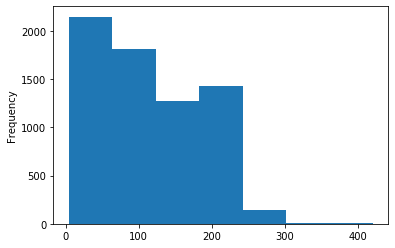

In [33]:
df.length.plot.hist(bins=7)

### Punctuation percentage

In [34]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text)-text.count(" ")),3)*100

df['punct']=df['raw'].apply(count_punct)

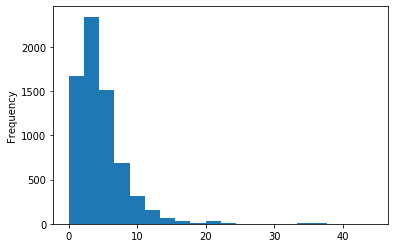

In [39]:
df.punct.plot.hist(bins=20)

In [49]:
df.punct.describe()

count    6839.000000
mean        4.508378
std         3.661170
min         0.000000
25%         2.300000
50%         3.900000
75%         5.900000
max        44.400000
Name: punct, dtype: float64

# 4. Data analysis

C:\Users\carol\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
C:\Users\carol\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


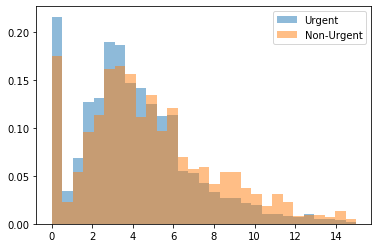

In [47]:
bins=np.linspace(0,15,30)
plt.hist(df[df.has_reply==True]['punct'],bins, alpha=0.5, normed=True, label='Urgent')
plt.hist(df[df.has_reply==False]['punct'],bins, alpha=0.5, normed=True, label='Non-Urgent')
plt.legend(loc='upper right')
plt.show()

Les features calculées n'ont pas l'air de différencier les tweets

In [52]:
df.reply_time.describe()

count    5182.000000
mean       29.248360
std       194.049617
min         0.000000
25%         3.000000
50%         5.000000
75%        10.000000
max      4435.000000
Name: reply_time, dtype: float64

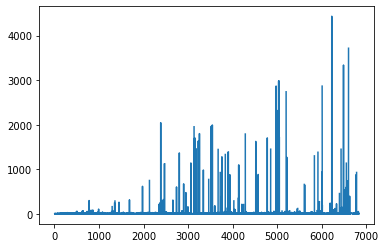

In [50]:
#Distribution of reply times
plt.plot(df['reply_time'])

# 5. Models

# 5A. Model creation 

## 1. Final pre-processing

In [29]:
df["clean_tweet"] = df["raw"].apply(lambda text: remove_uppercase(text))
df["clean_tweet"] = df["clean_tweet"].apply(lambda text: remove_punctuation(text))
df["clean_tweet"] = df["clean_tweet"].apply(lambda text: remove_stopwords(text))
#df["clean_tweet"] = df["clean_tweet"].apply(lambda text: remove_frequent_words(text))
df["clean_tweet"] = df["clean_tweet"].apply(lambda text: lemmatize_words(text))

In [30]:
df["clean_tweet_tokenized"] = df["clean_tweet"].apply(lambda text: tokenize(text))

In [31]:
df.columns

Index(['raw', 'reply_time', 'has_reply', 'length', 'punct', 'clean_tweet',
       'clean_tweet_tokenized'],
      dtype='object')

### Create dataset

In [32]:
matrix = CountVectorizer()
X = matrix.fit_transform(df.clean_tweet).toarray()

In [33]:
# Choose value to predict
y = df.has_reply

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.80,random_state=44)

## 2. Vectorization

In [35]:
def build_model(mode):
    # Intent to use default paramaters for show case
    vect = None
    if mode == 'count':
        vect = CountVectorizer()
    elif mode == 'tf':
        vect = TfidfVectorizer(use_idf=False, norm='l2')
    elif mode == 'tfidf':
        vect = TfidfVectorizer()
    #add n-gram
    else:
        raise ValueError('Mode should be either count or tfidf')
    
    return Pipeline([
        ('vect', vect),
        ('clf' , LogisticRegression(solver='newton-cg',n_jobs=-1))
    ])

## 3. Choose model

### Random Forest

In [36]:
rf = RandomForestClassifier()

In [ ]:
rf.fit(X_train,y_train)

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
model=rf

# 5B. Model evaluation

In [1]:
print('Performance on test set :')
print('\n')

print('Accuracy : %.3f ' % accuracy_score(y_test, y_pred))


Performance on test set :




NameError: name 'accuracy_score' is not defined

### Feature importance

### Confusion Matrix

In [ ]:
## PRINT SCORES

accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)


string = "RESULTATS \n \
         Accuracy : {accuracy}% \n \
Balanced Accuracy : {balanced_accuracy}% \n \
         F1 score : {f1}\n \
        Precision : {precision}% (how many selected items are relevant)\n \
           Recall : {recall}% (how many relevant items are selected)\n \
\n\n\
STATISTICS\n\
 Proportion of positives in test set    : {positives}%\n\
 Proportion of positives in predictions : {predicted_positives}%\
"

print(string.format(accuracy = round(100*accuracy,2),
                    balanced_accuracy = round(100*balanced_accuracy,2),
                    f1 = round(f1,4), 
                    precision = round(100*precision,2), 
                    recall = round(100*recall,2),
                    positives = round(100*y_test.sum()/len(y_test),2),
                    predicted_positives = round(100*y_pred.sum()/len(y_pred),2),
                   ))

In [ ]:
## DISPLAY ROC CURVE
roc_curve = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

plt.plot(roc_curve[0], roc_curve[1], color='darkorange',
         lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# CONFUSION MATRIX
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()